In [1]:
from lib import GeneratePseudoData, NLL, TestStatistic
from scipy import optimize
import pystan, os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
p_s_true = 0.1
lambda_tot_true = 100.

model_fixed_par = {
    "gaussian_mean" : 2000.0,
    "gaussian_sigma" : 10.0,
    "x_min" : 1900.0,
    "x_max" : 2100.0
    }

dat = GeneratePseudoData(p_s_true, lambda_tot_true, model_fixed_par)

In [3]:
print "background events", dat['N_b']
print "signal events", dat['N_s']

background events 88
signal events 12


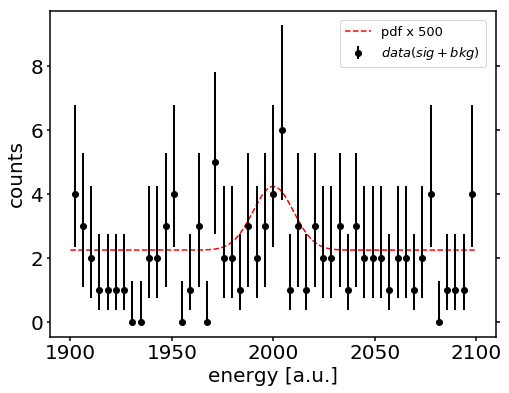

In [4]:
from helpers import get_poisson_confidence_intervals
from scipy.stats import norm
edges = np.linspace(model_fixed_par['x_min'], model_fixed_par['x_max'], 50)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

ctot, _ = np.histogram(dat['samples'], bins=edges)
ctot_low, ctot_up = get_poisson_confidence_intervals(ctot)

centers = 0.5*(edges[1:]+edges[:-1])
ax.errorbar(centers, ctot, yerr=[ctot_low, ctot_up], label='$data (sig+bkg)$', markersize = 6.0, color='black', fmt='o', zorder=20, elinewidth=2)
tx = np.linspace(model_fixed_par['x_min'], model_fixed_par['x_max'], 500)
ty = p_s_true * norm.pdf(tx, model_fixed_par['gaussian_mean'], model_fixed_par['gaussian_sigma']) + (1.-p_s_true) * 1./(model_fixed_par['x_max'] - model_fixed_par['x_min'])
scale = 500
plt.plot(tx, ty * scale, "r--", label="pdf x 500")
ax.set_xlabel('energy [a.u.]', fontsize=20)
ax.set_ylabel('counts', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')

plt.legend(bbox_to_anchor=[0.99, 0.99], loc='upper right', prop={'size':13}, ncol=1, fancybox=True)

plt.show()

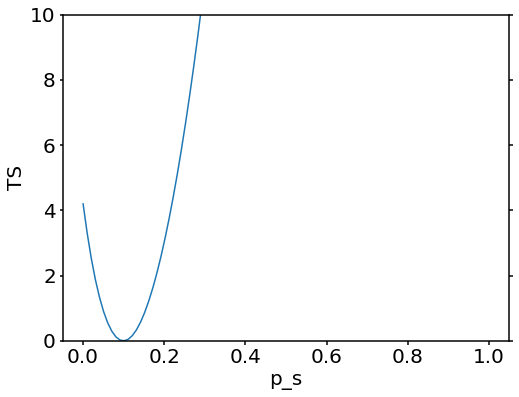

In [10]:
samples = dat["samples"]
N_s = dat["N_s"]
N_b = dat["N_b"]

def fmin_full_space(par):
    return NLL(samples = samples, p_s = par[1], lambda_tot = par[0], \
               model_fixed_par = model_fixed_par)

NLL_abs_min = optimize.minimize(fmin_full_space, (N_b+N_s, 0.5), \
                                bounds=((0.0, None), (0.0, 1.0)), \
                                options={'disp': False})

tps = np.linspace(0,1,100)
tnll = [2.0*NLL(samples = samples, p_s = k, lambda_tot = N_s+N_b, model_fixed_par = model_fixed_par) for k in tps]
tnll = np.asarray(tnll)-np.amin(tnll)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.plot(tps, tnll)
plt.ylim(0,10)
ax.set_xlabel('p_s', fontsize=20)
ax.set_ylabel('TS', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')

In [6]:
from scipy.stats import chi2

print NLL_abs_min
ts = TestStatistic(dat, 0.0, model_fixed_par)
print "observed LR test statistic:", ts
print "pvalue (approx)", chi2.sf(ts, 1) * 0.5

### code to sample the TSdist is in lib.py

      fun: 530.9546566877998
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -1.13686838e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 7
   status: 0
  success: True
        x: array([1.00000000e+02, 9.93026097e-02])
observed LR test statistic: 4.198873854164276
pvalue (approx) 0.02022541679373722


In [7]:
stan_code = """
data {
        int<lower=0> nobs;
        vector[nobs] xobs; 
        real<lower=0> gaussian_sigma;
        real gaussian_mean;
        real xmin;
        real xmax;
}

parameters {
        real<lower=0, upper=1> p_s;
        real<lower=0> lambda_tot; 
}

transformed parameters {
 
        real<lower=0> lambda_s;
        real<lower=0> lambda_b;
        
        lambda_s = p_s * lambda_tot;
        lambda_b = (1.0-p_s) * lambda_tot; 
}

model {
        // priors (arbitrary range for now)
        lambda_tot ~ uniform(0, 1000); 
        p_s ~ uniform(0.0, 1.0);

        // likelihood
        nobs ~ poisson(lambda_tot);
 
        for(i in 1:nobs)
                target+=log_mix(p_s, normal_lpdf(xobs[i] | gaussian_mean, gaussian_sigma), uniform_lpdf(xobs[i] | xmin, xmax));
                
}

"""

In [9]:
import pystan
import os

pp_dat = {'nobs' : N_s+N_b,
          'xobs' : samples, 
          'gaussian_sigma' : model_fixed_par['gaussian_sigma'],
          'gaussian_mean' : model_fixed_par['gaussian_mean'],
          'xmin' : model_fixed_par['x_min'],
          'xmax' : model_fixed_par['x_max']}

# set environmental variable STAN_NUM_THREADS
# Use 4 cores per chain
os.environ['STAN_NUM_THREADS'] = "4"
extra_compile_args = ['-pthread', '-DSTAN_THREADS']

#sm = pystan.StanModel(model_code=stan_code, extra_compile_args=extra_compile_args)
fit = sm.sampling(data=pp_dat, iter=1000000, chains=4, control={'adapt_delta':0.95})

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4bb468d31c15d91f9f65e5dc8ddf837f NOW.


In [13]:
print(fit)

Inference for Stan model: anon_model_4bb468d31c15d91f9f65e5dc8ddf837f.
4 chains, each with iter=1000000; warmup=500000; thin=1; 
post-warmup draws per chain=500000, total post-warmup draws=2000000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p_s          0.11  5.3e-5   0.05   0.02   0.07   0.11   0.14   0.22 945261    1.0
lambda_tot  101.0  9.9e-3  10.05  82.25  94.05 100.68 107.58 121.65  1.0e6    1.0
lambda_s    10.94  5.5e-3   5.37   1.77   7.04  10.53  14.35  22.57 938442    1.0
lambda_b    90.06    0.01  10.38  70.76  82.87  89.69  96.87 111.41  1.0e6    1.0
lp__       -166.0  1.7e-3   1.15 -169.1 -166.4 -165.7 -165.2 -164.9 483243    1.0

Samples were drawn using NUTS at Wed Jul 24 21:05:12 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


signal fraction


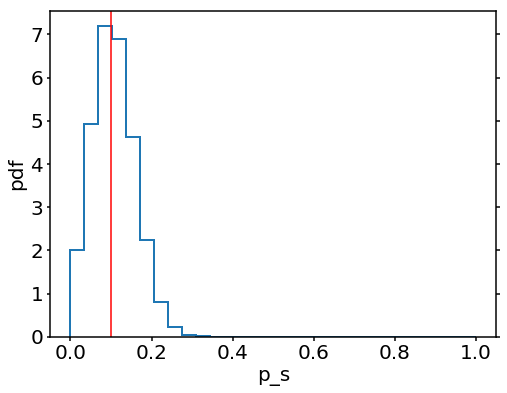

signal fraction


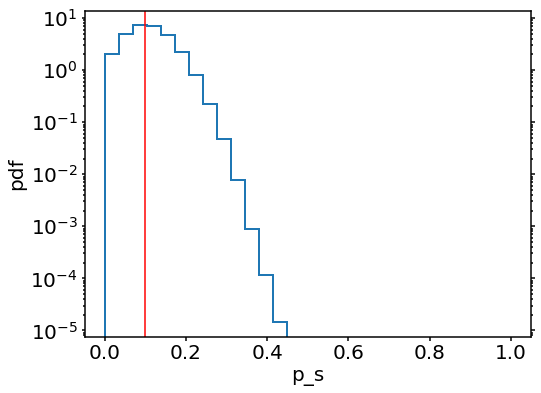

total rate


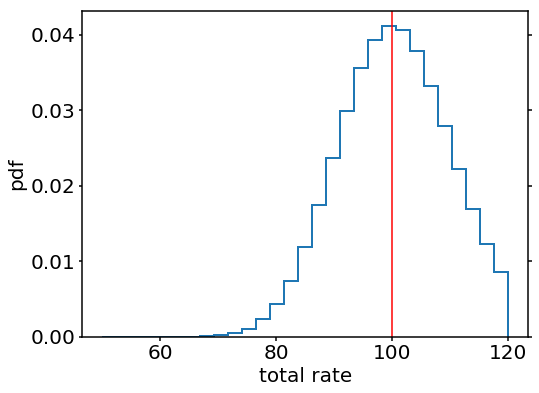

In [14]:
result = fit.extract()

print "signal fraction"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.hist(result['p_s'], bins=np.linspace(0,1,30), histtype='step', density=True, linewidth=2)
ax.set_xlabel('p_s', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
            
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.axvline(x=p_s_true, color='r')
plt.show()

print "signal fraction"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.hist(result['p_s'], bins=np.linspace(0,1,30), histtype='step', density=True, linewidth=2)
ax.set_xlabel('p_s', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
          
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.axvline(x=p_s_true, color='r')
plt.show()

print "total rate"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.hist(result['lambda_tot'], bins=np.linspace(50,120,30), histtype='step', density=True, linewidth=2)
ax.set_xlabel('total rate', fontsize=20)
ax.set_ylabel('pdf', fontsize=20)
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
            
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.axvline(x=lambda_tot_true, color='r')
plt.show()

In [15]:
eps = 0.00001
idx = result['p_s']<eps

nhit = len(result['p_s'][idx])*1.0
ntot = len(result['p_s'])
pdf_post = nhit / (ntot * eps)
pdf_prior = 1.

print "number of samples near ps=0:", nhit
print "estimated BF:",pdf_post / pdf_prior

number of samples near ps=0: 31.0
estimated BF: 1.55


In [16]:
def prior_transform(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    p_s = u[0]
    lambda_tot = u[1]
    lambda_tot *= 1000.
    return [p_s, lambda_tot]

In [17]:
def logl(x):
    p_s, lambda_tot = x
    # NLL(samples = samples, p_s = k, lambda_tot = N_s+N_b, model_fixed_par = model_fixed_par)
    return -1.0 * NLL(samples = samples, p_s = p_s, lambda_tot = lambda_tot, model_fixed_par = model_fixed_par)

In [18]:
from dynesty import NestedSampler # initialize our nested sampler
ndim = 2
sampler = NestedSampler(logl, prior_transform, ndim)

In [19]:
sampler.run_nested()
results = sampler.results
print results.summary()
logz = results.logz[-1]

iter: 3302 | +500 | bound: 5 | nc: 1 | ncall: 20742 | eff(%): 18.330 | loglstar:   -inf < -530.957 <    inf | logz: -536.710 +/-  0.137 | dlogz:  0.001 >  0.509                                      

Summary
nlive: 500
niter: 3302
ncall: 20742
eff(%): 18.330
logz: -536.710 +/-  0.137
None


In [20]:
def prior_transform(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""
    
    lambda_tot = u[0]
    lambda_tot *= 1000.
    return [lambda_tot]

In [21]:
def logl(x):
    lambda_tot = x[0]
    # NLL(samples = samples, p_s = k, lambda_tot = N_s+N_b, model_fixed_par = model_fixed_par)
    return -1.0 * NLL(samples = samples, p_s = 0.0, lambda_tot = lambda_tot, model_fixed_par = model_fixed_par)

In [22]:
from dynesty import NestedSampler # initialize our nested sampler
ndim = 1
sampler = NestedSampler(logl, prior_transform, ndim)

In [23]:
sampler.run_nested()
results = sampler.results
print results.summary()
logz2 = results.logz[-1]

iter: 2233 | +500 | bound: 2 | nc: 1 | ncall: 18344 | eff(%): 14.899 | loglstar:   -inf < -533.054 <    inf | logz: -536.614 +/-  0.090 | dlogz:  0.001 >  0.509                                      

Summary
nlive: 500
niter: 2233
ncall: 18344
eff(%): 14.899
logz: -536.614 +/-  0.090
None


In [24]:
print "BF=",np.exp(logz2) / np.exp(logz)
print "-2logBF=",-2*(logz2-logz)

BF= 1.1012555283006535
-2logBF= -0.19290183655789406


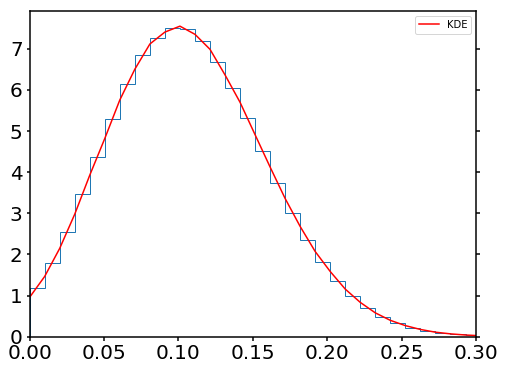

In [29]:
import pyqt_fit
from pyqt_fit import kde_methods, kde

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
est_lin = kde.KDE1D(result['p_s'], lower=0, method=kde_methods.linear_combination)
xs = np.linspace(0,1,100)
plt.plot(xs, est_lin(xs), 'y', label="KDE", color='red')
plt.legend(loc='best')
plt.hist(result['p_s'], histtype='step', density=True, bins=np.linspace(0,1,100))
plt.xlim([0.0,0.3])
for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')
            
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.axvline(x=lambda_tot_true, color='r')
plt.show()

In [28]:
print  "BF=",est_lin(0.0)

BF= 0.9601527895784275
